<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gender-classification" data-toc-modified-id="Classification">Gender Classification</a></span> <ul class="toc-item"><li><span><a href="#Importing-data" data-toc-modified-id="Importing-data-1.1">Importing data</a></span></li><li><span><a href="#Audio-Signal-Samples" data-toc-modified-id="Audio-Signal-Samples-1.2">Audio Signal Samples</a></span><li><span><a href="#Extracting-features" data-toc-modified-id="Extracting-features-1.3">Extracting features</a></span><li><span><a href="#Classification" data-toc-modified-id="Classification-1.4">Classification</a></span><ul class="toc-item"><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1.4.1">Naive Bayes</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-1.4.2">Logistic regression</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-1.4.3">SVM</a></span></li><li><span><a href="#Neural-Network" data-toc-modified-id="Neural-Network-1.4.4">Neural Network</a></span></li> <li><span><a href="#Deep-Convolutional-Network-1" data-toc-modified-id="Deep-Convolutional-Network-1-1.4.5">Deep Convolutional Network 1</a></span></li> <li><span><a href="#Deep-Convolutional-Network-2" data-toc-modified-id="Deep-Convolutional-Network-2-1.4.6">Deep Convolutional Network 2</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-1.5">Discussion</a></span><li><span><a href="#Further-Exploration" data-toc-modified-id="Further-Exploration-1.6">Further Exploration</a></span>

# Importing data

In [1]:
import glob, os
import pandas as pd
import numpy as np

In [2]:
speaker_labels = 'LibriSpeech/SPEAKERS.TXT'
data_root = 'LibriSpeech/dev-clean'

In [3]:
# Read labels text file
with open(speaker_labels, 'r') as f:
    content = f.readlines()
    
# Parse text file content
data = np.array(['Id', 'Sex', 'Subset', 'Minutes', 'Name'])
for line in content:
    if not line.startswith(';'):
        row = [item.strip() for item in line.split(' | ')] 
        data = np.vstack((data, row)) 
# Store in a dataframe   
df = pd.DataFrame(data=data[1:,:], columns=data[0,:])
df.head()

,Id,Sex,Subset,Minutes,Name
0,14,F,train-clean-360,25.03,Kristin LeMoine
1,16,F,train-clean-360,25.11,Alys AtteWater
2,17,M,train-clean-360,25.04,Gord Mackenzie
3,19,F,train-clean-100,25.19,Kara Shallenberg
4,20,F,train-other-500,30.07,Gesine


In [4]:
# Keep only the dev-clean set
df_clean = df[df.Subset == 'dev-clean']
df_clean.head()

,Id,Sex,Subset,Minutes,Name
46,84,F,dev-clean,8.02,Christie Nowak
93,174,M,dev-clean,8.04,Peter Eastman
135,251,M,dev-clean,8.04,Mark Nelson
200,422,M,dev-clean,8.38,President Lethe
279,652,M,dev-clean,8.31,Scott Walter


In [5]:
# loop through all files, select ".flac" files, and extract corresponding path and ID.
flac_files = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith('.flac'):
            file = os.path.join(root, filename)
            flac_files.append(file)

In [6]:
# Retrieve the sex of each speaker with the id, and then store in a dataframe
data = pd.DataFrame(columns=['filepath', 'sex'])
for file in flac_files:
    file_id = file.split('/')[2]
    sex = df_clean[df_clean.Id == file_id]['Sex'].iloc[0]
    data = data.append({'filepath': file, 'sex': sex}, ignore_index=True)

In [7]:
data.head()

,filepath,sex
0,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
1,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
2,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
3,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F
4,LibriSpeech/dev-clean/2412/153954/2412-153954-...,F


# Audio Signal Samples

Before we move into extracting the features, let us take a look at the signals in the some of the audio files under different forms:

In [8]:
# import main audio processing library
import librosa

In [9]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [10]:
# choosing some female and male sample files
female_sample_file = data[data.sex == 'F'].filepath.iloc[0]
sig_f, rate_f = librosa.load(female_sample_file)
male_sample_file = data[data.sex == 'M'].filepath.iloc[0]
sig_m, rate_m = librosa.load(male_sample_file)

In [11]:
# playing audio file
ipd.Audio(female_sample_file)

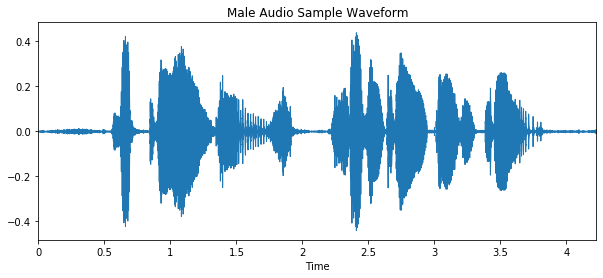

In [12]:
# displaying signal waveform
plt.figure(figsize=(10, 4))
librosa.display.waveplot(sig_m, sr=rate_m)
plt.title('Male Audio Sample Waveform')
plt.show()

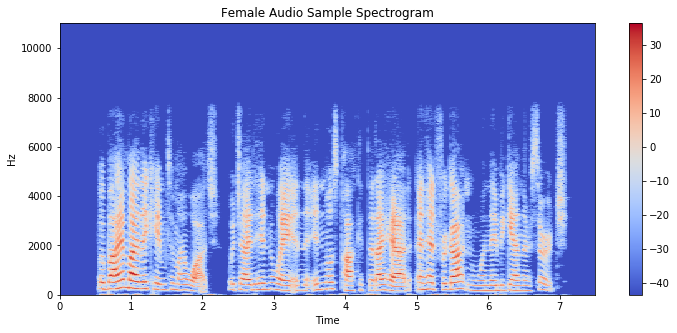

In [13]:
# displaying spectrogram
S = librosa.stft(sig_f)
S_db = librosa.amplitude_to_db(abs(S))
plt.figure(figsize=(12, 5))
librosa.display.specshow(S_db, sr=rate_f, x_axis='time', y_axis='hz') 
plt.title('Female Audio Sample Spectrogram')
plt.colorbar()
plt.show()

# Extracting features

In [14]:
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [15]:
X = []
for i in range(len(data)):
    # Extract signal and sampling rate of each file
    sig, rate = librosa.load(data.filepath.iloc[i])
    # Use them to get the mfcc features
    mfcc = librosa.feature.mfcc(y=sig, sr=rate)
    # Keep only the mean
    X.append([np.mean(e) for e in mfcc])
X = np.asarray(X)
print(f'There are {X.shape[0]} with {X.shape[1]} MFCC features each')

There are 2703 with 20 MFCC features each


In [16]:
# Store the features in a dataframe
mfcc_features = pd.DataFrame(data=X, columns=['mfcc' + str(i) for i in range(X.shape[1])])

In [17]:
# Rescale the features
scaler = StandardScaler()
X = scaler.fit_transform(np.array(mfcc_features, dtype = float))

# Encode the labels
encoder = LabelEncoder()
y = encoder.fit_transform(data.sex.tolist())

In [18]:
# Split the dataset: 0.70, 0.20, 0.10 (train, test, val) 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=14)

In [19]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1891, 20), (271, 20), (541, 20), (1891,), (271,), (541,))

# Classification

### Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
# create a classifier
clf = GaussianNB()
# train the classifier
clf.fit(X_train, y_train)
# test it
nb_score = clf.score(X_test, y_test)

In [22]:
print(f"Accuracy of Naive Bayes classifier : {nb_score}")

Accuracy of Naive Bayes classifier : 0.8262476894639557


### Logistic regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
# create a classifier
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
# train the classifier
clf.fit(X_train, y_train)
# test it
logreg_score = clf.score(X_test, y_test)

In [25]:
print(f"Accuracy of Logistic Regression's classifier : {logreg_score}")

Accuracy of Logistic Regression's classifier : 0.922365988909427


### SVM 

In [26]:
from sklearn.svm import SVC

In [27]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
svc_score = clf.score(X_test, y_test)

In [28]:
print(f"Accuracy of SVM classifier : {svc_score}")

Accuracy of SVM classifier : 0.9981515711645101


### Neural Network

In [29]:
# using Keras API with TensorFlow backend.
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [30]:
# Create the model and add the layers. 
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using train and validation set. 
hist = model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=512,
          validation_data=(X_val, y_val))

# Test our model. 
results = model.evaluate(X_test, y_test)

Train on 1891 samples, validate on 271 samples
Epoch 1/20
1891/1891 [==============================] - 0s 99us/step - loss: 0.5732 - accuracy: 0.7573 - val_loss: 0.3913 - val_accuracy: 0.8450
Epoch 2/20
1891/1891 [==============================] - 0s 19us/step - loss: 0.3173 - accuracy: 0.8969 - val_loss: 0.2051 - val_accuracy: 0.9373
Epoch 3/20
1891/1891 [==============================] - 0s 19us/step - loss: 0.1680 - accuracy: 0.9429 - val_loss: 0.1252 - val_accuracy: 0.9594
Epoch 4/20
1891/1891 [==============================] - 0s 17us/step - loss: 0.0979 - accuracy: 0.9630 - val_loss: 0.0976 - val_accuracy: 0.9705
Epoch 5/20
1891/1891 [==============================] - 0s 16us/step - loss: 0.0630 - accuracy: 0.9794 - val_loss: 0.0816 - val_accuracy: 0.9779
Epoch 6/20
1891/1891 [==============================] - 0s 18us/step - loss: 0.0452 - accuracy: 0.9863 - val_loss: 0.0655 - val_accuracy: 0.9889
Epoch 7/20
1891/1891 [==============================] - 0s 17us/step - loss: 0.0304

Testing Loss: 0.006383802303056665
Testing Accuracy: 0.996303141117096
Training Accuracy: 1.0
Validation Accuracy: 0.9926199316978455


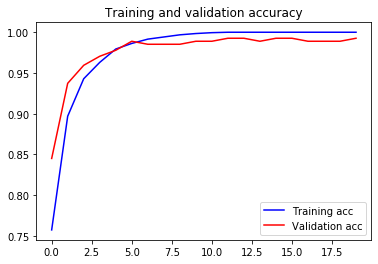

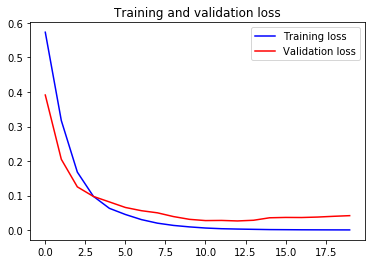

In [31]:
import matplotlib.pyplot as plt

# Retreive the accuracies and losses values from the training history.
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

print('Testing Loss:', results[0])
print('Testing Accuracy:', results[1])
print('Training Accuracy:', max(acc))
print('Validation Accuracy:', max(val_acc))

epochs = range(len(acc))

# Plot to visualise the accuracies.
plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot to visualise the losses.
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### Deep Convolutional Network 1

In [32]:
# Reshape our datatset 
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
y_val = np.expand_dims(y_val, axis=1)

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1891, 20, 1), (1891, 1), (541, 20, 1), (541, 1))

In [34]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dropout, MaxPooling1D, Dense

# Create the model
model = Sequential()

# Block 1
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(20,1)))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides= 2))
# Block 2
model.add(Conv1D(128, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(128, kernel_size= 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides= 2))
# Block 3
model.add(Conv1D(256, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(256, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(256, kernel_size= 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides= 2))
# Block 4
model.add(Conv1D(512, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(512, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(512, kernel_size= 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides=2))
#Classification Block
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model. 
hist = model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=512,
          validation_data=(X_val, y_val))

# Test the model.
results = model.evaluate(X_test, y_test)

Train on 1891 samples, validate on 271 samples
Epoch 1/20
1891/1891 [==============================] - 4s 2ms/step - loss: 0.6838 - accuracy: 0.5013 - val_loss: 0.6445 - val_accuracy: 0.5351
Epoch 2/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.6380 - accuracy: 0.6658 - val_loss: 0.5686 - val_accuracy: 0.6974
Epoch 3/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.5570 - accuracy: 0.7546 - val_loss: 0.5102 - val_accuracy: 0.8044
Epoch 4/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3837 - accuracy: 0.8784 - val_loss: 0.2242 - val_accuracy: 0.9483
Epoch 5/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.3167 - accuracy: 0.8895 - val_loss: 0.1835 - val_accuracy: 0.9410
Epoch 6/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.1959 - accuracy: 0.9418 - val_loss: 0.1692 - val_accuracy: 0.9446
Epoch 7/20
1891/1891 [==============================] - 3s 2ms/step - loss: 0.1309 - accu

Testing Loss: 0.1061911133261731
Testing Accuracy: 0.9796673059463501
Training Accuracy: 1.0
Validation Accuracy: 0.9926199316978455


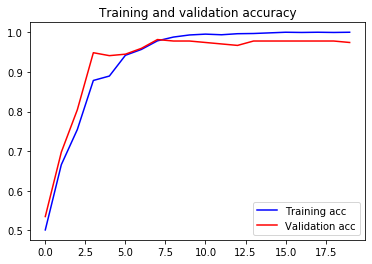

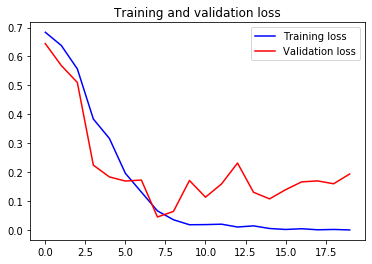

In [35]:
print('Testing Loss:', results[0])
print('Testing Accuracy:', results[1])
print('Training Accuracy:', max(acc))
print('Validation Accuracy:', max(val_acc))

# Retreive the accuracies and losses values from the training history.
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

# Plot to visualise the accuracies.
plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot to visualise the losses.
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

### Deep Convolutional Network 2

In [36]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras import regularizers

model = Sequential()

# Block 1
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(20,1), kernel_regularizer=regularizers.l1(l=0.1)))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides= 2))
# Block 2
model.add(Conv1D(128, kernel_size= 3, activation='relu', padding='same'))
model.add(Conv1D(128, kernel_size= 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size= 2, strides= 2))
# Classification Block
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train,
          y_train,
          epochs=30,
          batch_size=512,
          validation_data=(X_val, y_val))

results = model.evaluate(X_test, y_test)

Train on 1891 samples, validate on 271 samples
Epoch 1/30
1891/1891 [==============================] - 1s 278us/step - loss: 2.2501 - accuracy: 0.5246 - val_loss: 2.1680 - val_accuracy: 0.6827
Epoch 2/30
1891/1891 [==============================] - 0s 93us/step - loss: 2.1362 - accuracy: 0.6420 - val_loss: 2.0117 - val_accuracy: 0.7601
Epoch 3/30
1891/1891 [==============================] - 0s 92us/step - loss: 1.9785 - accuracy: 0.7414 - val_loss: 1.8218 - val_accuracy: 0.7970
Epoch 4/30
1891/1891 [==============================] - 0s 84us/step - loss: 1.8104 - accuracy: 0.7885 - val_loss: 1.7021 - val_accuracy: 0.8229
Epoch 5/30
1891/1891 [==============================] - 0s 92us/step - loss: 1.6598 - accuracy: 0.8371 - val_loss: 1.5437 - val_accuracy: 0.8524
Epoch 6/30
1891/1891 [==============================] - 0s 98us/step - loss: 1.5179 - accuracy: 0.8752 - val_loss: 1.3784 - val_accuracy: 0.9262
Epoch 7/30
1891/1891 [==============================] - 0s 87us/step - loss: 1.386

Testing Loss: 0.17839238615000755
Testing Accuracy: 0.9907578825950623
Training Accuracy: 1.0
Validation Accuracy: 0.9815497994422913


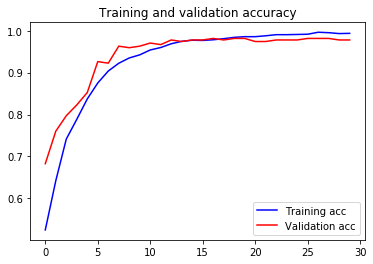

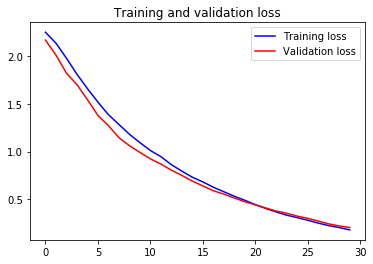

In [37]:
print('Testing Loss:', results[0])
print('Testing Accuracy:', results[1])
print('Training Accuracy:', max(acc))
print('Validation Accuracy:', max(val_acc))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.figure()
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Discussion

Let us state our observations regarding the different methods implemented above.
* Logistic Regression performs well, better than Naive Bayes. It has an accuracy of 0.92, compared to 0.83 for the Naive Bayes. 
* SVM outperforms by far the two others (Naive Bayes and Logistic Regression) with its accuracy of 0.99
* A Neural Network composed of five linear (or dense) layers performs very good also. Trained on 20 epochs, it has a test accuracy of 0.99 and a training accuracy of 1.0
* A Deep Neural Network 1 with 4 blocks of convolution layers and maxpooling, and 1 block of classification performs well in general (trained on 20 epochs, it has a test accuracy of 0.97 and a training accuracy of 1.0. We plotted the accuracies and losses on the train and the validation set. We observe that the loss is going down until a point, and then it starts going up again. This could be a sign of overfitting. To avoid it, we tested a new architecture (Deep Neural Network 2)
* A Deep Neural Network 2 with 2 blocks of convolution layers and maxpooling, and 1 block of classification performs well too. We removed some blocks to reduce the capacity of the network (this is a good trick to fight overfitting), and added a regularization term as a penalty. The accuracies are similar (a little better : 0.99 of test accuracy) to the ones got in the first architecture, but the curves of the loss doesnt reveal any overfitting anymore.

To conclude this, SVM is very fast and seems to work (a little bit too much) well. Neural Networks and Convolutional Neural Networks give also very satisfying results. 

# Further Exploration

Now that we've extracted the MFCC features from our files and ran different classifiers and assessed their performance, we'd like to quickly look at whether extracting more features is beneficial for our task. The MFCC features are the most well adapted to characterize the human voice, so it might be that this extra step isn't very useful, but let's consider it and take a look anyway.

We have some new possible features, like the chroma frequencies, spectral centroid, bandwidth, and rolloff, and the zero crossing rate. These features can help characterize music, but we'll see how well they can help in our speech recognition task. Let us recreate the dataset with all our new features:

In [38]:
X = []
for i in range(len(data)):
    sig, rate = librosa.load(data.filepath.iloc[i])
    mfcc = librosa.feature.mfcc(y=sig, sr=rate)
    zero_crossing_r = np.mean(librosa.feature.zero_crossing_rate(sig))
    sp_centroid = np.mean(librosa.feature.spectral_centroid(y=sig, sr=rate))
    sp_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=sig, sr=rate))
    sp_rolloff = np.mean(librosa.feature.spectral_rolloff(y=sig, sr=rate))
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=sig, sr=rate))
    f = [np.mean(e) for e in mfcc]
    f.extend([zero_crossing_r, sp_centroid, sp_bandwidth, sp_rolloff, chroma_stft])
    X.append(f)
X = np.asarray(X)
cols = ['mfcc' + str(i) for i in range(20)]
cols.extend(['zero_crossing_rate', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'chroma_stft'])
all_features = pd.DataFrame(data=X, columns=cols)
all_features.head()

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,zero_crossing_rate,spectral_centroid,spectral_bandwidth,spectral_rolloff,chroma_stft
0,-376.618958,92.578377,-53.060528,37.844734,-15.922381,-20.242741,-15.200622,-16.003004,3.895925,-5.885455,...,-6.527479,-0.900801,-6.621924,-3.586226,-0.736886,0.121952,2034.678920,1422.337547,3541.178587,0.304169
1,-456.230072,61.065781,-32.265972,30.490004,-14.630162,-6.279855,-9.422338,-11.758070,2.781771,-1.318170,...,-5.426578,-1.487148,-3.772203,0.614894,3.307419,0.160275,2370.954636,1768.427374,4459.432745,0.298258
2,-407.316071,90.937416,-44.725742,43.616219,-14.885650,-13.028865,-11.439718,-17.402895,-4.826096,-3.850803,...,-6.050762,-0.320178,-6.544166,-1.635568,-0.386387,0.126199,2027.496358,1528.046038,3708.754356,0.314393
3,-365.826263,104.142784,-57.753094,27.549694,-17.683661,-11.755156,-8.536755,-20.601931,-7.353552,-1.944544,...,-10.797341,-3.357937,-7.989599,-3.329295,-2.385308,0.121507,1928.770170,1421.776237,3386.050180,0.300437
4,-381.881775,102.449043,-61.538120,51.567215,-13.671814,-13.852193,-12.276953,-19.686152,-1.152872,-6.167706,...,-9.136578,-0.007080,-7.341861,-3.260023,-2.485450,0.116105,1936.128749,1436.823314,3447.527344,0.329065


In [39]:
# rescale features
scaler = StandardScaler()
X = scaler.fit_transform(np.array(all_features, dtype = float))
# encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(data.sex.tolist())
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=14)

Now, let's rerun some of our previous experiments to see if there are any noticeable improvements:

In [40]:
# Gaussian Naive Bayes
clf = GaussianNB().fit(X_train, y_train)
nb_score = clf.score(X_test, y_test)
# Logistic Regression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
logreg_score = clf.score(X_test, y_test)
# SVM
clf = SVC(gamma='auto').fit(X_train, y_train)
svc_score = clf.score(X_test, y_test)

In [41]:
print(f"Accuracy of Naive Baye's classifier : {nb_score}")
print(f"Accuracy of Logistic Regression's classifier : {logreg_score}")
print(f"Accuracy of SVM classifier : {svc_score}")

Accuracy of Naive Baye's classifier : 0.8059149722735675
Accuracy of Logistic Regression's classifier : 0.9408502772643254
Accuracy of SVM classifier : 0.9981515711645101


We can see that there isn't a significant difference in testing accuracy for the Naive Bayes or the SVM classifier, but that there a +2% boost in accuracy for the Logistic Regression classifier.

How about when we run these experiments with our new features, but without including the MFCC?

In [42]:
# rescale features
scaler = StandardScaler()
X = scaler.fit_transform(np.array(all_features.iloc[:,20:], dtype = float))
# encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(data.sex.tolist())
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=14)

In [43]:
# Gaussian Naive Bayes
clf = GaussianNB().fit(X_train, y_train)
nb_score = clf.score(X_test, y_test)
# Logistic Regression
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
logreg_score = clf.score(X_test, y_test)
# SVM
clf = SVC(gamma='auto').fit(X_train, y_train)
svc_score = clf.score(X_test, y_test)

In [44]:
print(f"Accuracy of Naive Baye's classifier : {nb_score}")
print(f"Accuracy of Logistic Regression's classifier : {logreg_score}")
print(f"Accuracy of Logistic Regression's classifier : {svc_score}")

Accuracy of Naive Baye's classifier : 0.7282809611829945
Accuracy of Logistic Regression's classifier : 0.7837338262476895
Accuracy of Logistic Regression's classifier : 0.7874306839186691


The accuracy of all classifiers has dropped significantly, so we can safely say that the MFC Coefficients are the most important in our application, and they provide the most information regarding the sex of a speaker.